In [18]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [767]:
i = 0

In [769]:
for image_name in os.listdir('/content/drive/MyDrive/GAN/singular summoning circle - Search Images'):
    i += 1
    img = cv2.imread(os.path.join('/content/drive/MyDrive/GAN/singular summoning circle - Search Images', image_name))
    resized_image = cv2.resize(img, (128, 128))
    image_array = np.array(resized_image)
    grayscale = rgb_to_grayscale(image_array)
    image = Image.fromarray(grayscale)
    image.save(os.path.join(folder_path, "images", "h", f'image{i}.jpeg'))

In [3]:
folder_path = '/content/drive/MyDrive/GAN'

In [4]:
def rgb_to_grayscale(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]

    grayscale_image = 0.2989 * R + 0.5870 * G + 0.1140 * B
    grayscale_image = np.clip(grayscale_image, 0, 255).astype(np.uint8)

    return grayscale_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
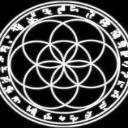

In [805]:
img = cv2.imread('/content/drive/MyDrive/GAN/images/h/image105.jpeg', cv2.IMREAD_GRAYSCALE)

bw_image_array = np.array(img)
bw_image_array

In [19]:
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = img_to_array(img)
        img_array = (img_array / 127.5) - 1.0
        images.append(img_array)
    return np.array(images)

In [20]:
path = os.path.join(folder_path, "images", "h")
path
np_image_array = load_images_from_folder(path)

In [21]:
np_image_array.shape

(139, 128, 128, 1)

In [22]:
np.random.seed(42)
indices = np.random.permutation(np_image_array.shape[0])
images_np = np_image_array[indices]

In [23]:
images_np.shape

(139, 128, 128, 1)

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((images_np))

In [25]:
ds = dataset.cache()
ds = ds.shuffle(60000)
ds = ds.batch(7)

In [26]:
ds.as_numpy_iterator().next().shape

(7, 128, 128, 1)

In [786]:
ds.shape()

AttributeError: '_BatchDataset' object has no attribute 'shape'

In [27]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [28]:
from tensorflow.keras import layers

In [29]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.dense = layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,))
        self.reshape = layers.Reshape((8, 8, 256))
        self.conv1 = layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False)
        self.batchnorm1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()

        self.conv2 = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)
        self.batchnorm2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()

        self.conv3 = layers.Conv2DTranspose(32, 5, strides=2, padding='same', use_bias=False)
        self.batchnorm3 = layers.BatchNormalization()
        self.relu3 = layers.ReLU()

        self.conv4 = layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='tanh')

    def call(self, inputs, training=False):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.batchnorm1(x, training=training)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x, training=training)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x, training=training)
        x = self.relu3(x)

        x = self.conv4(x)
        return x

In [30]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(128, 128, 1))
        self.leaky_relu1 = layers.LeakyReLU(alpha=0.2)

        self.conv2 = layers.Conv2D(128, 5, strides=2, padding='same')
        self.batchnorm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU(alpha=0.2)

        self.conv3 = layers.Conv2D(256, 5, strides=2, padding='same')
        self.batchnorm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU(alpha=0.2)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.leaky_relu1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x, training=training)
        x = self.leaky_relu2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x, training=training)
        x = self.leaky_relu3(x)

        x = self.flatten(x)
        x = self.dense(x)
        return x

In [31]:
class ScircleGAN(Model):
    def __init__(self, generator, discriminator):
        super(ScircleGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss_fn, d_loss_fn):
        super(ScircleGAN, self).compile()
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn

    def train_step(self, real_images):
        batch_size = real_images.shape[0]
        noise = tf.random.normal([batch_size, 100])
        fake_images = self.generator(noise, training=True)

        with tf.GradientTape() as d_tape:
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            d_loss_real = self.d_loss_fn(real_labels, real_output)
            d_loss_fake = self.d_loss_fn(fake_labels, fake_output)

            total_d_loss = (d_loss_real + d_loss_fake) / 2

        d_gradients = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            fake_images = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_images, training=False)

            g_loss = self.g_loss_fn(real_labels, fake_output)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": g_loss}

In [32]:
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-5)

g_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
dataset = ds.shuffle(buffer_size=10000)

generator = Generator()
discriminator = Discriminator()
scircle_gan = ScircleGAN(generator, discriminator)

scircle_gan.compile(g_opt, d_opt, g_loss_fn, d_loss_fn)

def plot_generated_images(epoch, generator, examples=4, dim=(4, 1), figsize=(1, 1)):
    noise = tf.random.normal([examples, 100])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2.0

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    axs = axs.flatten()

    for i in range(examples):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch+1}.png')
    plt.show()

epochs = 20
for epoch in range(epochs):
    for real_images in dataset:
        losses = scircle_gan.train_step(real_images)

    print(f"Epoch {epoch+1}, d_loss: {losses['d_loss']}, g_loss: {losses['g_loss']}")
    plot_generated_images(epoch, generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, 

Epoch 1, d_loss: 0.504891037940979, g_loss: 0.7386083602905273


Epoch 2, d_loss: 0.16034342348575592, g_loss: 0.8812366724014282


Epoch 3, d_loss: 0.47177717089653015, g_loss: 0.9287497401237488


Epoch 4, d_loss: 0.24824334681034088, g_loss: 1.2806413173675537


Epoch 5, d_loss: 0.35499662160873413, g_loss: 1.1952191591262817


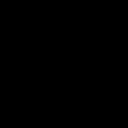

In [812]:
cv2_imshow(generator.call(tf.random.normal([1, 100])).numpy().squeeze())

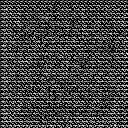

In [819]:
cv2_imshow((generator.call(tf.random.normal([1, 100])).numpy()*255).squeeze())